#PREDICCIÓN DE POSIBLE CÁNCER DE PRÓSTATA A PARTIR DE MRI POR MEDIO DE CNN 2D Y 3D#

Gabriel Felipe Vega Ochoa - 2170122

Andrés Felipe Cabeza Serrano - 2162106 

Kevin Dlaikan Castillo - 2160090



**Antecedentes**

Existen varias maneras de detectar cáncer de próstata, por ejemplo la prueba de antígenos, pero por costos y por efectividad, la que se ha ido democratizando son las imágenes por ultrasonido, sin embargo no eran muy eficientes debido a la poca resolución de las mismas, a partir del 2014 se comenzó a usar el MRI la cual se estandarizó por tener una resolución más alta en las imágenes. (https://arxiv.org/pdf/2106.01835.pdf)

Hoy en día el diagnóstico de cáncer de próstata se hace por medio de humano-máquina, es decir médicos expertos se ayudan con ML para un mejor diagnóstico.

Con la aparición de las CNN en este campo se ha ido progresando en el diagnóstico de cáncer de prostata.

**Introducción**

Teniendo en cuenta de que el cáncer de próstata afecta a 1 de cada 8 hombres y su dificultad para clasificarlo, se quiere proponer un modelo de Deep Learning que facilite la clasificación de cáncer por medio de MRI.

El objetivo del notebook es tomar las MRI de pacientes divididas en 60 imágenes asociadas a un puntaje de UCLA entre 0-5 en los cuales entre más alto es el número, mayor es la posibilidad de que el cáncer sea de mayor gravedad.

Lo más común es usar el método PIRADS que asocia un puntaje a la posibilidad de tener cáncer de próstata, pero para este caso se usará UCLA que es similar al método PIRADS (columna presente en el dataset)

**Dataset** 

Se utilizó el dataset **Prostate-MRI-US-Biopsy**
https://doi.org/10.7937/TCIA.2020.A61IOC1A

Que cuenta con 2799 estudios, compuestos estos por volúmenes de imágenes generados por medio de resonancia magnética, con un total de 61,119 imágenes, adicionalmente se tiene el puntaje UCLA y algunas características adicionales

**Montar el Drive**



---


  **PLEASE USE THIS CELL IF YOU ARE RUNNING IN A *¡¡GCP VM!!***

<H1>Ejecutar solo en máquina virtual google cloud</H1>

In [ ]:
#@title **Google Drive Mount** 
#@markdown >>***don't edit this cell****

#@markdown Google Drive can be used as Persistance HDD for files.<br>

#@markdown **Choose a method (GDFuse Recommended)**
mount_method = "GDFuse" #@param ["GDFuse", "Native"]


#@markdown **Options for GDFuse** <br>
#@markdown - Visit https://github.com/astrada/google-drive-ocamlfuse/wiki/Team-Drives
label = "MyDrive" #@param {type:"string"}
mount_team_drive = False #@param {type:"boolean"}
force_mount = True #@param {type:"boolean"}

import os
import subprocess


class Drive():
    creds = {}
    mountpoint = ""
    deps = False
    
    debug = False

    def __init__(self, mountpoint="/content/drive/", debug=False):
        os.makedirs(mountpoint, exist_ok=True)
        self.mountpoint = mountpoint
        self.debug = debug

    def _mount_gdfuse(self, mount_dir):
        os.makedirs(mount_dir, exist_ok=True)

        subprocess.run(
            ['google-drive-ocamlfuse',
             '-o',
             'allow_other',
             '-label',
             label,
             mount_dir,
            ]
        )

        print(f"Drive Mounted at {mount_dir}. If you get input/output error, then `team_drive_id` might be wrong or not accessible.")

    def _unmount_gdfuse(self, mount_dir):
        subprocess.run(
            ['fusermount',
             '-u',
             mount_dir,
            ]
        )
        os.rmdir(mount_dir)

    def auth(self):
        from google.colab import auth
        from oauth2client.client import GoogleCredentials

        auth.authenticate_user()
        
        creds = GoogleCredentials.get_application_default()
        self.creds = {
            "id": creds.client_id,
            "secret": creds.client_secret
        }

    def gdfuse(self, label, mound_team_drive=False, force_mount=False):
        import getpass

        if not self.creds:
            self.auth()

        if not self.deps:
            print("Installing google-drive-ocamlfuse")
            subprocess.run(['apt', 'install', 'software-properties-common python-software-properties module-init-tools', '-y'])
            subprocess.run(['add-apt-repository', 'ppa:alessandro-strada/ppa', '-y'])
            subprocess.run(['apt', 'update'])
            subprocess.run(['apt', 'install', '--assume-yes', 'google-drive-ocamlfuse'])
            self.deps = True

        base_dir = '/root/.gdfuse'
        config_dir = f'{base_dir}/{label}'
        mount_dir = f"{self.mountpoint}/{label}"

        if force_mount and os.path.exists(mount_dir):
            self._unmount_gdfuse(mount_dir)
        elif os.path.exists(mount_dir):
            print("Drive already mounted")
            return

        if not os.path.exists(config_dir) or force_mount:
            print(f"Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id={self.creds['id']}&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force")
            vcode = getpass.getpass("Enter the Auth Code: ")

            subprocess.run(
              ['google-drive-ocamlfuse',
                '-headless',
                '-id',
                self.creds['id'],
                '-secret',
                self.creds['secret'],
                '-label',
                label,
              ],
                text=True,
                input=vcode
            )

        if mount_team_drive:
            team_drive_id = input("Enter Team Drive ID: ")

            subprocess.run(
                ['sed',
                 '-i',
                 f's/team_drive_id=.*$/team_drive_id={team_drive_id}/g',
                 f'{config_dir}/config'
                ]
            )
        else:
            subprocess.run(
                ['sed',
                 '-i',
                 f's/team_drive_id=.*$/team_drive_id=/g',
                 f'{config_dir}/config'
                ]
            )

        self._mount_gdfuse(mount_dir)


    def native(self):
        from google.colab import drive
        mount_dir = f"{self.mountpoint}/Native"
        drive.mount(mount_dir)

if 'drive' not in globals():
    try:
        drive = Drive(f"/home/{username}/drive")
    except NameError:
        drive = Drive('/content/drive')

if mount_method == "Native":
    drive.native()
if mount_method == "GDFuse":
    drive.gdfuse(label, mount_team_drive, force_mount)

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Enter the Auth Code: ··········
Drive Mounted at /content/drive/MyDrive. If you get input/output error, then `team_drive_id` might be wrong or not accessible.




---



In [ ]:
!mv drives drive

mv: cannot stat 'drives': No such file or directory


In [ ]:
%cd drive/MyDrive/IA2/TrabajoFinal/

/content/drive/MyDrive/IA2/TrabajoFinal



<br>



---

**Ejecutar para colab normalmente**

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/IA2/TrabajoFinal')
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/IA2/TrabajoFinal




---



**Importar librerías**

In [ ]:
!pip install pydicom

In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
import pydicom as dicom
import cv2
print(tf.__version__)

2.8.0


In [ ]:
lista = pd.read_excel('Dataset/Target Data_2019-12-05.xlsx')

In [ ]:
lista.head()

,UCLA Score (Similar to PIRADS v2),ROI Volume (cc),Target No.,seriesInstanceUID_US,seriesInstanceUID_MR,Patient ID
0,3.0,0.834323,1.0,1.3.6.1.4.1.14519.5.2.1.1403678967890026014493...,1.3.6.1.4.1.14519.5.2.1.2667179699843439819630...,Prostate-MRI-US-Biopsy-0001
1,3.0,0.834323,1.0,1.3.6.1.4.1.14519.5.2.1.1202285930413120999892...,1.3.6.1.4.1.14519.5.2.1.2667179699843439819630...,Prostate-MRI-US-Biopsy-0001
2,1.0,0.364729,1.0,1.3.6.1.4.1.14519.5.2.1.9782151183163602689533...,1.3.6.1.4.1.14519.5.2.1.1867491288236660505887...,Prostate-MRI-US-Biopsy-0002
3,3.0,0.364729,1.0,1.3.6.1.4.1.14519.5.2.1.2007760325377179554571...,1.3.6.1.4.1.14519.5.2.1.1867491288236660505887...,Prostate-MRI-US-Biopsy-0002
4,3.0,0.884436,1.0,1.3.6.1.4.1.14519.5.2.1.9358385420720256123337...,1.3.6.1.4.1.14519.5.2.1.1345819869189093607538...,Prostate-MRI-US-Biopsy-0003


In [ ]:
lista = lista[lista['Patient ID']!="Prostate-MRI-US-Biopsy-1148"]

Es necesario acceder a las MRI de cada paciente que contienen un total de 60 imágenes, pero debido a que las tomografías son procesos dinámicos dónde se toma un recorrido, algunos de estas imágenes no corresponden a la próstata, adicionalmente se aprovechó la cercanía de imágenes consecutivas y se toman 2 imágenes "vecinas" a la principal, y así tener un dataset de mayor tamaño

In [ ]:
def numToDir(medio,total):
  if(medio <10):
    num="0"+str(medio)
  elif (total<100):
    num=str(medio)
  else:
    num="0"+str(medio)
  return num

In [ ]:
rutas=[]
for i in lista['Patient ID'][:1282]:
  name = '/content/drive/MyDrive/IA2/TrabajoFinal/Dataset/junior/Prostate-MRI-US-Biopsy/'+i+'/'
  print(i)
  # try:
  for j in next(os.walk(name))[1]:
    if "MR" in j:
      name+=j+"/"
      break
  name+=(next(os.walk(name))[1][0])+"/";
  total=len([namedir for namedir in os.listdir(name)])
  medio = int(total/2)
  num=numToDir(medio,total)
  name1=name+"1-"+numToDir(medio-1,total)+".dcm"
  name2=name+"1-"+numToDir(medio+1,total)+".dcm"
  name+="1-"+num+".dcm"
  rutas.append(name1)
  rutas.append(name)
  rutas.append(name2)
  print(name)
  # except:
  #   break

for i in lista['Patient ID'][1282:]:
  name = '/content/drive/MyDrive/IA2/TrabajoFinal/Dataset/junior_2_parte/Prostate-MRI-US-Biopsy/'+i+'/'
  print(i)
  for j in next(os.walk(name))[1]:
    if "MR" in j:
      name+=j+"/"
      break
  name+=(next(os.walk(name))[1][0])+"/";
  total=len([namedir for namedir in os.listdir(name)])
  medio = int(total/2)
  num=numToDir(medio,total)
  name1=name+"1-"+numToDir(medio-1,total)+".dcm"
  name2=name+"1-"+numToDir(medio+1,total)+".dcm"
  name+="1-"+num+".dcm"
  rutas.append(name1)
  rutas.append(name)
  rutas.append(name2)
  
  print(name)

Prostate-MRI-US-Biopsy-0001
/content/drive/MyDrive/IA2/TrabajoFinal/Dataset/junior/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0001/06-28-2009-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2_spc_rst_axial obl_Prostate-90221/1-30.dcm
Prostate-MRI-US-Biopsy-0001
/content/drive/MyDrive/IA2/TrabajoFinal/Dataset/junior/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0001/06-28-2009-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2_spc_rst_axial obl_Prostate-90221/1-30.dcm
Prostate-MRI-US-Biopsy-0002
/content/drive/MyDrive/IA2/TrabajoFinal/Dataset/junior/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0002/03-26-2009-MRI PROSTATE W WO CONTRAST-20097/10.000000-t2_spc_rst_axial obl_Prostate-22803/1-30.dcm
Prostate-MRI-US-Biopsy-0002
/content/drive/MyDrive/IA2/TrabajoFinal/Dataset/junior/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0002/03-26-2009-MRI PROSTATE W WO CONTRAST-20097/10.000000-t2_spc_rst_axial obl_Prostate-22803/1-30.dcm
Prostate-MRI-US-Biopsy-0003
/content/drive/MyDrive/IA2/TrabajoFinal/

KeyboardInterrupt: ignored

In [ ]:
# Eliminamos columnas innecesarias
del lista["seriesInstanceUID_US"]
del lista["seriesInstanceUID_MR"]

In [ ]:
labels=lista["UCLA Score (Similar to PIRADS v2)"]
labels2=labels.to_numpy()
labels2 = labels2.tolist()

In [ ]:
labels3=[]
for i in labels2:
  for j in range(3):
    labels3.append(i)

Se creó un dataset a mano asociando el puntaje con las rutas de la imagen ya que venían de manera separada

In [ ]:
data=pd.DataFrame(data={"Score":labels3,"Path":rutas})

In [ ]:
data = pd.read_csv("Dataset/dataframe_xy.csv")

In [ ]:
data

,Unnamed: 0,Subject ID,Number of Images,File Location,UCLA Score
0,0,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0
1,1,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0
2,2,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0
3,3,Prostate-MRI-US-Biopsy-0002,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,1.0
4,4,Prostate-MRI-US-Biopsy-0002,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,1.0
...,...,...,...,...,...
3037,3037,Prostate-MRI-US-Biopsy-1150,25,Dataset/junior_2_parte/Prostate-MRI-US-Biopsy/...,4.0
3038,3038,Prostate-MRI-US-Biopsy-1150,25,Dataset/junior_2_parte/Prostate-MRI-US-Biopsy/...,4.0
3039,3039,Prostate-MRI-US-Biopsy-1151,60,Dataset/junior_2_parte/Prostate-MRI-US-Biopsy/...,0.0
3040,3040,Prostate-MRI-US-Biopsy-1151,60,Dataset/junior_2_parte/Prostate-MRI-US-Biopsy/...,0.0


In [ ]:
#@title Se almacena en un dataset para evitar realizar el mismo proceso en repetidas ocasiones
data.to_csv("/content/drive/MyDrive/IA2/TrabajoFinal/XYdata.csv")

**Leemos el dataset**

In [ ]:
dataset = pd.read_csv('Dataset/dataframe.csv')

**DATASET CON EL PUNTAJE**

In [ ]:
print(dataset.shape)
dataset.head()

(7098, 5)


,Unnamed: 0,Subject ID,Number of Images,File Location,UCLA Score
0,0,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0
1,1,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0
2,2,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0
3,3,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0
4,4,Prostate-MRI-US-Biopsy-0001,60,Dataset/junior/Prostate-MRI-US-Biopsy/Prostate...,3.0


**Tomamos las datos de X y Y**

In [ ]:
images = dataset.iloc[:, 3].values
labels = dataset.iloc[:, 4].values


**Realizamos el preprocesamiento**

Las imágenes están en formato .dcm que es un formato especial para imágenes médicas, por tanto es necesario instalar la libreria de un tercero para poder abrirla, procesarla y convertirla en RGB para poder ser recibida por la red neuronal.

In [ ]:
target_size = (72,72)

In [ ]:
def process_image(imgs, datos):
  for image in datos:
    ds = dicom.dcmread(image)
    numpy_image = ds.pixel_array 
    resized_image = cv2.resize(numpy_image, dsize=target_size, interpolation=cv2.INTER_CUBIC)
    imgs.append((np.repeat(resized_image[..., np.newaxis], 3, -1)))

Vamos a usar varios hilos para agilizar la eficacia para procesamiento de imágenes

In [ ]:
from multiprocessing import cpu_count
cpu_count()

2

In [ ]:
len(data["File Location"])

3042

In [ ]:
3042/4

760.5

In [ ]:
#@title **Procesamiento de imágen multinúcleo** [Code]
#@markdown Con la librería `multiprocessing` 🚀

#@markdown Procesamiento con 2 núcleos y 2 hilos

from multiprocessing import Process, Manager

procesos = []
images = []
l = 761 #Result of len(data["Path"])/4
images2 = np.array([])
print("Starting image processing...\n")
with Manager() as manager:
  #Create 4 threads
  for i in range(1,5):
    imgs = manager.list()
    images.append(imgs)
    p = Process(target=process_image, args=(images[i-1] ,data["File Location"][l*(i-1):l*i]))
    procesos.append(p)
    procesos[i-1].start()
    print("Launch thread",i)
  
  #Join first process to asign `images2` to first result list and can do a `np.concatenate`
  procesos[0].join()
  images2 = np.array(images[0])
  #Join all process and use np.concatenate to combine all arrays
  for i in range(1,4):
    procesos[i].join()
    images2 = np.concatenate((images2,np.array(images[i])),axis=0)
  print("\nAll threads ended")
  del images
  del procesos
images = images2
print(len(images))

Starting image processing...

Launch thread 1
Launch thread 2
Launch thread 3
Launch thread 4

All threads ended
3042


In [ ]:
images.shape

(3042, 72, 72, 3)

In [ ]:
np.save("images_3.npy",images)

In [ ]:
images=np.load("images_3.npy")

Imágenes en escala de grises

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


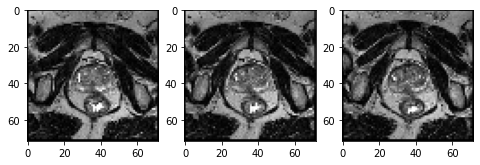

In [ ]:
plt.figure(figsize=(8, 10))
plt.subplot(1,3,1)
plt.imshow(images[18])
plt.subplot(1,3,2)
plt.imshow(images[19])
plt.subplot(1,3,3)
plt.imshow(images[20])

**NORMALIZAR**

In [ ]:
labels=data["UCLA Score"]

In [ ]:
train_im = np.array(images)
y = np.array(labels)
x = train_im.reshape([-1, target_size[0],target_size[1], 3])
x = x.astype('float32')

y = tf.keras.utils.to_categorical(y)
 
x /= 255
x.shape
y.shape

(3042, 6)

**PARTIR DATOS DE TEST Y TRAIN**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,  train_size=0.7,shuffle=True)


**CONSTRUIR LA CNN EN 2D**

In [ ]:
#@title Define CNN architecture
model_inDrop = tf.keras.models.Sequential()
model_inDrop.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', bias_initializer='he_normal', padding='same', input_shape=(72, 72, 3)))
model_inDrop.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model_inDrop.add(tf.keras.layers.MaxPooling2D((2, 2)))
#model_inDrop.add(tf.keras.layers.AveragePooling2D((2, 2)))
model_inDrop.add(tf.keras.layers.Dropout(0.3))
model_inDrop.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', bias_initializer='he_normal', padding='same'))
model_inDrop.add(tf.keras.layers.BatchNormalization())
model_inDrop.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model_inDrop.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', bias_initializer='he_normal', padding='same'))
model_inDrop.add(tf.keras.layers.BatchNormalization())
model_inDrop.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model_inDrop.add(tf.keras.layers.AveragePooling2D((2, 2)))
model_inDrop.add(tf.keras.layers.Dropout(0.3))
model_inDrop.add(tf.keras.layers.Flatten())
model_inDrop.add(tf.keras.layers.Dense(32, kernel_initializer='glorot_normal', bias_initializer='he_normal',  activation='relu'))
model_inDrop.add(tf.keras.layers.Dropout(0.3))
model_inDrop.add(tf.keras.layers.Dense(6, activation='softmax'))

model_inDrop.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 72, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 36, 36, 64)       256       
 ormalization)                                          

**COMPILE**

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_inDrop.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

**TRAIN**

Epoch 1/100
67/67 [==============================] - 14s 73ms/step - loss: 1.8974 - accuracy: 0.3448 - val_loss: 1.7759 - val_accuracy: 0.3034
Epoch 2/100
67/67 [==============================] - 4s 53ms/step - loss: 1.6427 - accuracy: 0.3476 - val_loss: 3.1492 - val_accuracy: 0.0909
Epoch 3/100
67/67 [==============================] - 3s 49ms/step - loss: 1.6221 - accuracy: 0.3471 - val_loss: 4.8324 - val_accuracy: 0.0570
Epoch 4/100
67/67 [==============================] - 4s 53ms/step - loss: 1.6275 - accuracy: 0.3382 - val_loss: 5.6877 - val_accuracy: 0.0515
Epoch 5/100
67/67 [==============================] - 3s 50ms/step - loss: 1.5754 - accuracy: 0.3598 - val_loss: 5.5555 - val_accuracy: 0.0624
Epoch 6/100
67/67 [==============================] - 3s 49ms/step - loss: 1.5656 - accuracy: 0.3617 - val_loss: 4.9131 - val_accuracy: 0.1183
Epoch 7/100
67/67 [==============================] - 3s 49ms/step - loss: 1.5349 - accuracy: 0.3340 - val_loss: 5.0423 - val_accuracy: 0.0876
Epoch

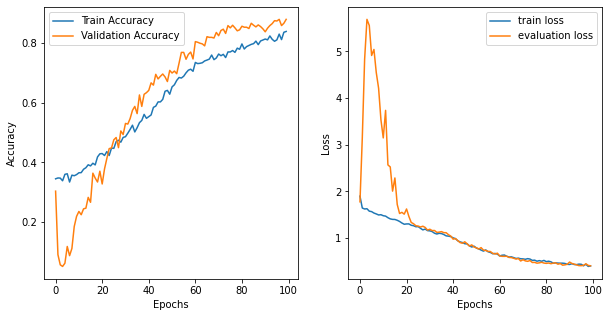

In [ ]:
#@title **code** Training

# model_CNN.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
import matplotlib.pyplot as plt
history = model_inDrop.fit(x_train, y_train, epochs=100,verbose=1, batch_size=32,validation_data=(x_test, y_test))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


In [ ]:
img1=x_test[10]

In [ ]:
model_inDrop.save('models/model2D.h5')

In [ ]:
model_inDrop = tf.keras.models.load_model('models/model2D.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Activations
Esperado 3  obtenido 3 : True


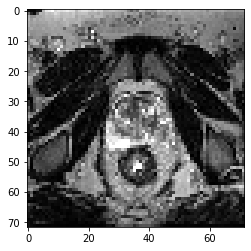

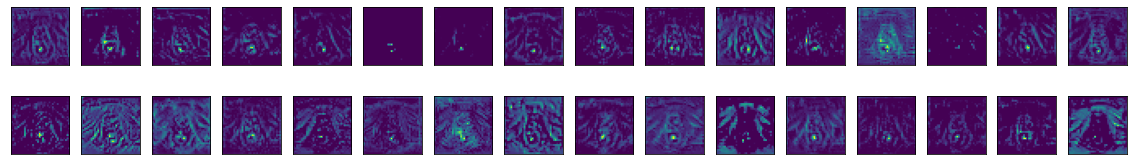

In [ ]:
indice =  50#@param {type:"integer"}
plt.imshow(x_test[indice], cmap='viridis')
layer_outputs = [layer.output for layer in model_inDrop.layers ]
activation_model = tf.keras.models.Model(inputs=model_inDrop.input, outputs=layer_outputs)
# array = np.expand_dims(, axis=0)
activations = activation_model.predict(x_test[indice].reshape(1,72,72,3))
print("Activations")
plt.figure(figsize=(20,3))
for i in range(32):
    plt.subplot(2,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(activations[5][0,:, :, i], cmap='viridis')
predicho = np.argmax(model_inDrop.predict(x_test[indice].reshape(1,72,72,3)))
esperado = np.argmax(y_test[indice])
print("Esperado",esperado, " obtenido", predicho, ":", esperado==predicho)

# **XMASNET**

Existe una red del estado del arte llamada XMasNet que ha comprobado tener buenos resultados para este tipo de problema, inspiado en este paper, se va a implementar esta red para la clasificación del problema de cáncer de próstata en 2d.

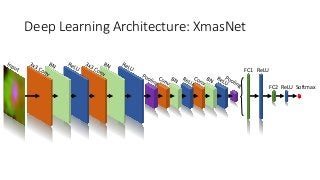

**Build CNN XMasNet**

In [ ]:
y_train

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
#@title Define CNN architecture
xmasnet = tf.keras.models.Sequential()
xmasnet.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(72, 72, 3))),
xmasnet.add(tf.keras.layers.BatchNormalization()),
xmasnet.add(tf.keras.layers.Activation(tf.keras.activations.relu)),
xmasnet.add(tf.keras.layers.Conv2D(32, (3, 3))),
xmasnet.add(tf.keras.layers.BatchNormalization()),
xmasnet.add(tf.keras.layers.Activation(tf.keras.activations.relu)),
xmasnet.add(tf.keras.layers.MaxPooling2D((2, 2)))
xmasnet.add(tf.keras.layers.x(32, (3, 3))),
xmasnet.add(tf.keras.layers.BatchNormalization()),
xmasnet.add(tf.keras.layers.Activation(tf.keras.activations.relu)),
xmasnet.add(tf.keras.layers.Conv2D(32, (3, 3))),
xmasnet.add(tf.keras.layers.BatchNormalization()),
xmasnet.add(tf.keras.layers.Activation(tf.keras.activations.relu)),
xmasnet.add(tf.keras.layers.MaxPooling2D((2, 2)))
xmasnet.add(tf.keras.layers.Flatten()),
xmasnet.add(tf.keras.layers.Dense(1024, activation='relu')),
xmasnet.add(tf.keras.layers.Dense(256, activation='relu')),
xmasnet.add(tf.keras.layers.Dense(6, activation='softmax'))

xmasnet.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 70, 70, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 70, 70, 32)       128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 70, 70, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 68, 68, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 68, 68, 32)       128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 68, 68, 32)      

**Compilar y entrenar**

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
xmasnet.compile(optimizer=opt, loss='mse',metrics=['accuracy'])

In [ ]:
print(x_train.shape)
print(y_train.shape)

(3402, 72, 72, 3)
(3402, 6)


Epoch 1/50
107/107 [==============================] - 14s 39ms/step - loss: 0.1452 - accuracy: 0.3836 - val_loss: 0.1178 - val_accuracy: 0.4143
Epoch 2/50
107/107 [==============================] - 3s 33ms/step - loss: 0.1264 - accuracy: 0.4168 - val_loss: 0.1223 - val_accuracy: 0.3642
Epoch 3/50
107/107 [==============================] - 4s 37ms/step - loss: 0.1150 - accuracy: 0.4636 - val_loss: 0.1166 - val_accuracy: 0.4170
Epoch 4/50
107/107 [==============================] - 5s 43ms/step - loss: 0.1096 - accuracy: 0.5026 - val_loss: 0.1196 - val_accuracy: 0.4053
Epoch 5/50
107/107 [==============================] - 4s 40ms/step - loss: 0.0991 - accuracy: 0.5650 - val_loss: 0.1090 - val_accuracy: 0.4925
Epoch 6/50
107/107 [==============================] - 4s 34ms/step - loss: 0.0924 - accuracy: 0.6026 - val_loss: 0.1039 - val_accuracy: 0.5254
Epoch 7/50
107/107 [==============================] - 3s 33ms/step - loss: 0.0824 - accuracy: 0.6576 - val_loss: 0.0991 - val_accuracy: 0.557

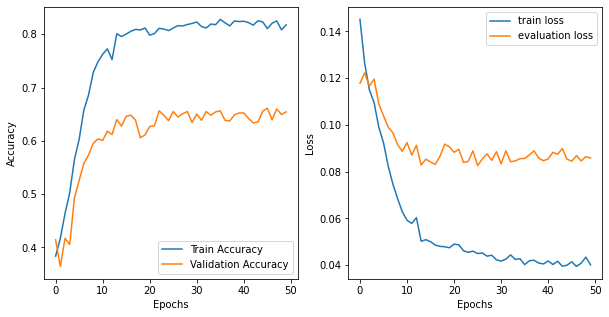

In [ ]:
#@title **code** Training

# model_CNN.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
import matplotlib.pyplot as plt
history = xmasnet.fit(x_train, y_train, epochs=50,verbose=1, batch_size=32,validation_data=(x_test, y_test))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


## ENFOQUE 3D 

Se propuso una red y se trabajó con una red del estado del arte en dos dimensiones, ahora se va a realizar el estudio con una red en tres dimensiones con volúmenes de imágenes.

En los temas vistos en clase se trataron convoluciones en 2d, pero para este caso se investigó para realizar las convoluciones en 3d, para dos dimensiones es necesario pasar el batch de imágenes ya sea en escala de grises RGB u otro cmap, pero para este caso se van a tomar volúmenes conformadas con 9 imágenes por volumen a una red convolucional en 3 dimensiones

**Procesamiento de imágenes en 3d**

Se van a tomar volúmenes de 7 imágenes

In [ ]:
target_size = (50,50)

In [ ]:
def process_image_3d(imgs, datos, labels_procesadinhos, labels):
  
  for i in range(16,len(datos)+1,16):
    vol=[]
    labels_procesadinhos.append(labels[i-15])
    for j in range(i-15, i,1):
      try:
        ds = dicom.dcmread(datos[j])
      except:
        print("ERROR:",datos[j])
        datos[j] = datos[j][:-5]+str(int(datos[j][-5])+1)+".dcm"
        ds = dicom.dcmread(datos[j])
      numpy_image = ds.pixel_array 
      resized_image = cv2.resize(numpy_image, dsize=target_size, interpolation=cv2.INTER_CUBIC)
      vol.append((np.repeat(resized_image[..., np.newaxis], 3, -1)))
    imgs.append(vol)



In [ ]:
dataset16 = pd.read_csv('Dataset/dataframe_16.csv')

In [ ]:
rutas=dataset16['File Location'].values
labels_ini=dataset16['UCLA Score'].values

In [ ]:
labels = []
for i in range(0,len(labels_ini),16):
  labels.append(labels_ini[i])

In [ ]:
len(labels)

1965

In [ ]:
rutas=dataset['File Location'].values
labels_ini=dataset['UCLA Score'].values


In [ ]:
#@title **Procesamiento de imágen multinúcleo** [Code]
#@markdown Using `multiprocessing` library 🚀

#@markdown Procesamiento con 2 núcleos y 2 hilos por núcleo

from multiprocessing import Process, Manager

procesos = []
images = []
labels_procesadinhos=[]
l = 3549 #Result of len(data["Path"])/2
images2 = np.array([])
print("Starting image processing...\n")
with Manager() as manager:
  #Create 4 threads
  for i in range(1,3):
    imgs = manager.list()
    labels_proc = manager.list()
    images.append(imgs)
    labels_procesadinhos.append(labels_proc)
    p = Process(target=process_image_3d, args=(images[i-1] ,rutas[l*(i-1):l*i], labels_procesadinhos[i-1],labels_ini[l*(i-1):l*i]))
    procesos.append(p)
    procesos[i-1].start()
    print("Launch thread",i)
  
  #Join first process to asign `images2` to first result list and can do a `np.concatenate`
  procesos[0].join()
  images2 = np.array(images[0])
  labels2=np.array(labels_procesadinhos[0])
  #Join all process and use np.concatenate to combine all arrays
  for i in range(1,2):
    procesos[i].join()
    images2 = np.concatenate((images2,np.array(images[i])),axis=0)
    labels2 = np.concatenate((labels2,np.array(labels_procesadinhos[i])),axis=0)
  print("\nAll threads ended")
  
  del images
  del procesos
  del labels_procesadinhos

images = images2
labels=labels2
print(len(images),len(labels))

Starting image processing...

Launch thread 1
Launch thread 2

All threads ended
442 442


In [ ]:
!ls "Dataset/junior/Prostate-MRI-US-Biopsy/" | tail

Prostate-MRI-US-Biopsy-0841
Prostate-MRI-US-Biopsy-0842
Prostate-MRI-US-Biopsy-0843
Prostate-MRI-US-Biopsy-0844
Prostate-MRI-US-Biopsy-0845
Prostate-MRI-US-Biopsy-0846
Prostate-MRI-US-Biopsy-0847
Prostate-MRI-US-Biopsy-0848
Prostate-MRI-US-Biopsy-0849
Prostate-MRI-US-Biopsy-0850


Preparar datos de entrenamiento y test

In [ ]:
np.save("vol_completo_50_50_15.npy",images)

In [ ]:
images=np.load("vol_completo_50_50_15.npy")

In [ ]:
np.save("labels_15.npy",labels)

In [ ]:
images.shape


(442, 15, 50, 50, 3)

In [ ]:
train_im = np.array(images)
y = np.array(labels)
x = train_im.reshape([-1, target_size[0],target_size[1], 15, 3])
x = x.astype('float32')

y = tf.keras.utils.to_categorical(y)
 
x /= 255
x.shape
y.shape

(442, 6)

Partir datos de entrenamiento y test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,  train_size=0.7,shuffle=True)


Las imágenes quedan guardadas en un numpy array y como la celda anterior dura un tiempo considerable en ejecutarse, se guardó el array de numpy como un binario para ser leído posteriormente y no tener que ejecutar el procesamiento cada vez que se ejecute el notebook.

In [ ]:
!ls -ahl

total 864M
-rw------- 1 root root 202K Feb  9 18:26  CNN.ipynb
-rw------- 1 root root 799K Mar  9 03:29  Copia_de_Trabajo_Final_Gv.ipynb
drwx------ 4 root root 4.0K Jan 24 15:28  Dataset
-rw------- 1 root root 396K Jan 24 17:06  DownloadDataSet.ipynb
-rw------- 1 root root 381K Jan 26 14:05  DownloadDataSetParte1.ipynb
-rw------- 1 root root 181M Mar 15 07:18  images_3.npy
drwx------ 2 root root 4.0K Mar 15 07:25  models
-rw------- 1 root root 2.9M Feb 19 01:32  OpenImage.ipynb
-rw------- 1 root root 590K Mar 15 06:49  TF_kd.ipynb
-rw------- 1 root root 378K Mar 15 04:08  Trabajo_Final_Final.ipynb
-rw------- 1 root root 804K Mar 15 07:56 'Trabajo Final_IA2.ipynb'
-rw------- 1 root root 108K Mar  8 10:18  Untitled0.ipynb
-rw------- 1 root root  67M Mar  6 22:12  vol_1.npy
-rw------- 1 root root 190M Mar 15 04:11  vol_completo_50_50_15.npy
-rw------- 1 root root 204M Mar 15 02:43  vol_completo_50_50.npy
-rw------- 1 root root  84M Mar  9 00:51  vol_completo_conelcodigodekevinxd.npy
-rw--

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


Ahora vamos a gráficar los volúmenes en 3d, es decir, como van cambiando los frames a lo largo del tiempo

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

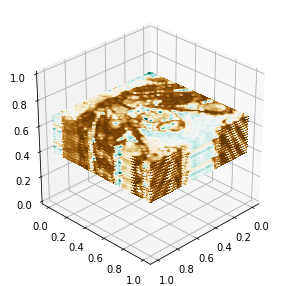

In [ ]:
#%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5,5))
xx, yy = np.meshgrid(np.linspace(0,1,50), np.linspace(0,1,50))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy

ax = fig.add_subplot(111, projection='3d')
# ax = Axes3D(fig)

for i in range(15):
  # ax.plot(images[18][i][0],images[18][i][1],i)
# ax.plot(X,Y,rgb2gray(images[18][0]))
  ax.contourf(X, Y, rgb2gray(images[18][i]), 100, zdir='z', offset=0.4+(i/50), cmap=cm.BrBG)
  
  ax.set_zlim((0.,1))
  ax.view_init(30, 45)
  # ax.contourf(X, Y, (rgb2gray(images[18][1])), 100, zdir='z', offset=0.6, cmap=cm.BrBG)

# for angle in range(0, 360):
#   ax.view_init(30, angle)
#   plt.draw()
#   plt.pause(.001)
plt.show()

In [ ]:
!pip install ipympl

Contruir la CNN en 3d

In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization
import keras
from keras import layers

width=50
height=50
#imágenes por volumen
depth=15

model_3d = tf.keras.models.Sequential()
model_3d.add(tf.keras.layers.Conv3D(256, (3,3,3), strides=(1,1,1), kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same', activation='relu', input_shape=(width, height, depth, 3)))
model_3d.add(tf.keras.layers.BatchNormalization())
model_3d.add(tf.keras.layers.Conv3D(128, (3,3,3), strides=(1,1,1), activation='relu', input_shape=(width, height, depth, 3)))
model_3d.add(tf.keras.layers.Conv3D(64, (3,3,3), strides=(1,1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
# model_3d.add(tf.keras.layers.Conv3D(64, (3,3,3), strides=(1,1,1), activation='relu', kernel_initializer='he_normal', bias_initializer='he_normal', padding='same'))
model_3d.add(tf.keras.layers.BatchNormalization())
model_3d.add(tf.keras.layers.MaxPooling3D((2,2,2)))
model_3d.add(tf.keras.layers.Dropout(0.2))
# model_3d.add(tf.keras.layers.Conv3D(128, (3,3,3), strides=(1,1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_normal', padding='same'))
# model_3d.add(tf.keras.layers.BatchNormalization())
# model_3d.add(tf.keras.layers.MaxPooling3D((2,2,2), strides=(2,2,2)))
# model_3d.add(tf.keras.layers.Dropout(0.2))
model_3d.add(tf.keras.layers.Conv3D(64, (3,3,3), strides=(1,1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
# model_3d.add(tf.keras.layers.BatchNormalization())
model_3d.add(tf.keras.layers.Conv3D(32, (3,3,3), strides=(1,1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model_3d.add(tf.keras.layers.BatchNormalization())
model_3d.add(tf.keras.layers.MaxPooling3D((2,2,2)))
model_3d.add(tf.keras.layers.Dropout(0.3))
model_3d.add(tf.keras.layers.Flatten())
model_3d.add(tf.keras.layers.Dense(128, activation='relu')),
model_3d.add(tf.keras.layers.Dense(64, activation='relu')),
model_3d.add(tf.keras.layers.Dense(32, activation='relu')),
model_3d.add(tf.keras.layers.Dense(6, activation='softmax'))


model_3d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 50, 50, 15, 256)   20992     
                                                                 
 batch_normalization_3 (Batc  (None, 50, 50, 15, 256)  1024      
 hNormalization)                                                 
                                                                 
 conv3d_6 (Conv3D)           (None, 48, 48, 13, 128)   884864    
                                                                 
 conv3d_7 (Conv3D)           (None, 48, 48, 13, 64)    221248    
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 13, 64)   256       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 24, 24, 6, 64)   

In [ ]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt = tf.keras.optimizers.Adadelta(
    learning_rate=0.00001, rho=0.85)

# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.0001)
model_3d.compile(optimizer=opt,loss='mse',metrics=['accuracy','mse'])

Epoch 1/25
10/10 [==============================] - 74s 6s/step - loss: 0.1548 - accuracy: 0.1974 - mse: 0.1548 - val_loss: 0.1393 - val_accuracy: 0.0977 - val_mse: 0.1393
Epoch 2/25
10/10 [==============================] - 45s 4s/step - loss: 0.1496 - accuracy: 0.2071 - mse: 0.1496 - val_loss: 0.1379 - val_accuracy: 0.2105 - val_mse: 0.1379
Epoch 3/25
10/10 [==============================] - 45s 4s/step - loss: 0.1549 - accuracy: 0.1586 - mse: 0.1549 - val_loss: 0.1370 - val_accuracy: 0.2707 - val_mse: 0.1370
Epoch 4/25
10/10 [==============================] - 45s 4s/step - loss: 0.1515 - accuracy: 0.1715 - mse: 0.1515 - val_loss: 0.1365 - val_accuracy: 0.2782 - val_mse: 0.1365
Epoch 5/25
10/10 [==============================] - 45s 5s/step - loss: 0.1516 - accuracy: 0.1715 - mse: 0.1516 - val_loss: 0.1364 - val_accuracy: 0.3008 - val_mse: 0.1364
Epoch 6/25
10/10 [==============================] - 45s 4s/step - loss: 0.1551 - accuracy: 0.1553 - mse: 0.1551 - val_loss: 0.1364 - val_acc

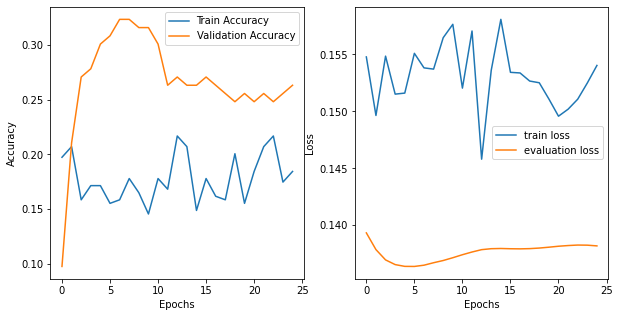

In [ ]:
import matplotlib.pyplot as plt
history = model_3d.fit(x_train, y_train, epochs=25,verbose=1, batch_size=32,validation_data=(x_test, y_test))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


# CONCLUSIONES



*   Se tomaron dos enfoques, en 3d y 2d, para 2d se propuso una red y obtuvo un mejor resultado que la XMasNet que es una red propuesta del estado del arte.
*   Las redes de transfer learning funcionan para las imágenes en 2d, se investigó y por ejemplo la VGG16 tiene capas Conv2D, es decir en 2 dimensiones y no es una buena prácticar aplicarla con volúmenes de imágenes.
*   Para la red neuronal en 2d, los datos para entrenamiento fueran batch con imágenes normales en escala de grises por su normalización, para la red neuronal en 3d, se contruyó un volúmen de 7 imágenes, esto porque no todas las resonancias tenían las 60 imágenes y se tomaban imágenes centrales ya que no en todas las imágenes se evidenciaba la presencia del tumor, sino se evidenciaba el recto del paciente.
*   El dataset estaba bastante desordenado, eso da hincapié a los problemas de la vida real, por ejemplo habían MRI que se saltaban algunos frames, habían pacientes con varios MRI y con diferentes puntajes e incluso otros que nisiquiera tenían y los datos del puntaje o los labels no estaban en el mismo dataset del path de las imágenes, por eso se recurrió a crear un dataset que tuviera los labels y el path de las imágenes de las MRI.
*   Para el trabajo con volúmenes (CNN 3D), a pesar de hacer varios modelos y varias aproximaciones, aumenta o reduciendo la cantidad de capas de un volumen, no se obtuvo un buen puntaje, ni un buen comportamiento en las curvas de accuracy y pérdida. Esto se puede deber a que al realizar este proceso no se tenían suficientes imágenes, para este caso se quizo explorar el data augmentation para volúmenes (cómo el descrito en el artículo [Automatic Data Augmentation for 3D Medical
Image Segmentation](https://arxiv.org/pdf/2010.11695.pdf), sin embargo por la complejidad del método no se incluyó en el alcance del proyecto. 